In [1]:
import pandas as pd
import numpy as np

from scipy.io import wavfile
file = "/home/peterr/macocu/task6_speech/data/00009874.flac.wav"

def get_duration(file:str) -> float:
    rate, data = wavfile.read(file)
    return len(data)/rate

get_duration(file)


pd.set_option("display.max_colwidth", 100)
f = "/home/nikolal/projects/parlaspeech/transcripts_normalized.txt"
df = pd.read_table(f, names=["unknown1", "path", "sentence"],
        #nrows=2000
        )

df["path"] = "/home/peterr/macocu/task6_speech/data/" + df.path.str.replace("flac/", "") + ".wav"
df["duration"] = df.path.apply(get_duration)
df = df.drop(columns="unknown1")
import os
df["filesize"] = df["path"].apply(os.path.getsize)
for char in ['*', ':', ';']:
    df["sentence"] = df.sentence.str.replace(char, "")
df.sort_values(by="filesize", ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(5)

,path,sentence,duration,filesize
0,/home/peterr/macocu/task6_speech/data/00009875.flac.wav,znači žalili su se zbog dugotrajnosti rješavanja postupka na sudovima na rad i ponašanje pojedin...,114.4,3660878
1,/home/peterr/macocu/task6_speech/data/00018811.flac.wav,formiranje nacionalne politike i kada mi danas raspravljamo o tome što je glavni uzrok nepostoja...,85.0,2720078
2,/home/peterr/macocu/task6_speech/data/00006520.flac.wav,ovakvo je to kretanje u dvanaest mjesecu dvije tisuće deset godine imali smo dvadeset pet tisuća...,80.6,2579278
3,/home/peterr/macocu/task6_speech/data/00014693.flac.wav,pa evo kolega paneniću vi ste spomenuli jedinice lokalne i regionalne samouprave da oni imaju ve...,79.6,2547278
4,/home/peterr/macocu/task6_speech/data/00007188.flac.wav,dakle stav kluba hadezea je dakle da je ovo vrlo kvalitetan pomak u smislu mijenjanja načina rad...,74.6,2387278


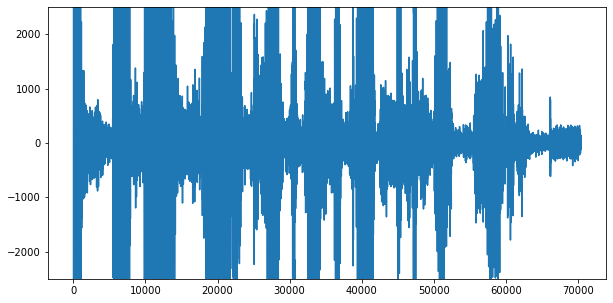

In [3]:
import audioop
import matplotlib.pyplot as plt
rate, data = wavfile.read(file)
plt.figure(figsize=(10,5))
plt.plot(data)
plt.ylim((-2500, 2500))
plt.show()

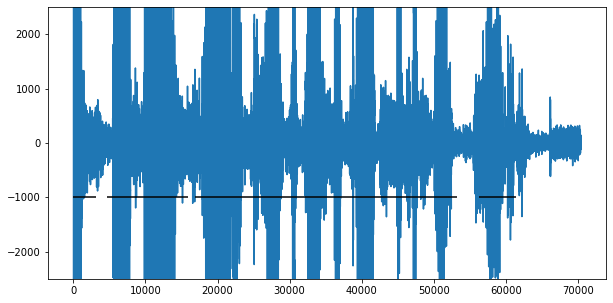

In [18]:
import librosa
nonsilent_parts = librosa.effects.split(
    data.astype(np.float), 
    frame_length = int(0.2*16000), 
    top_db=15)
plt.figure(figsize=(10,5))
plt.plot(data)
plt.ylim((-2500, 2500))

for begin, end in nonsilent_parts:
    plt.hlines(-1000, begin, end, zorder=10)

plt.show()


In [29]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

sound_file = AudioSegment.from_wav(file)
audio_chunks = split_on_silence(sound_file, min_silence_len=200, silence_thresh=-40 )


In [31]:
audio_chunks[0]